In [1]:
import os
import errno
import torch
import timeit
import imageio
import numpy as np
import torch.nn as nn
from adamW import AdamW
from torch.utils import data
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
# customized functions:
from Loss import noisy_label_loss_binary
from Utilis import segmentation_scores, CustomDataset_punet, calculate_cm
from Utilis import evaluate_noisy_label_4, evaluate_noisy_label_5, evaluate_noisy_label_6
# our proposed model:
from Models import UNet_CMs

In [2]:
# ========================= #
# Hyper-parameters setting
# ========================= #

# hyper-parameters for model:
input_dim = 3 # dimension of input
width = 32 # width of the network
depth = 3 # depth of the network, downsampling times is (depth-1)
class_no = 2 # class number, 2 for binary

# hyper-parameters for training:
train_batchsize = 5 # batch size
alpha = 0.1 # weight of the trace regularisation of learnt confusion matrices
num_epochs = 50 # total epochs
learning_rate = 0.001 # learning rate

The dimension of image, channel:3, height:28, width:28
The dimension of label, channel:1, height:28, width:28


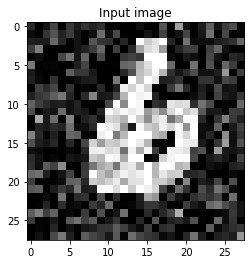

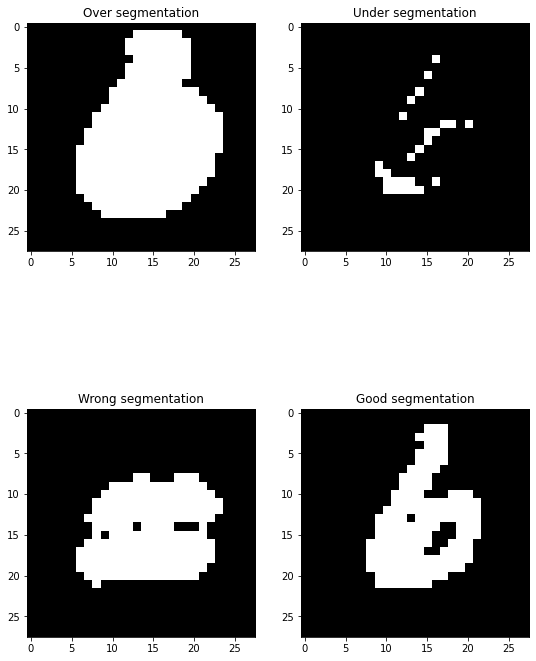

In [3]:
# ======================================= #
# Prepare a few data examples from MNIST 
# ======================================= #

# Change path for your own datasets here:
data_path = './MNIST_examples'
dataset_tag = 'mnist'
label_mode = 'multi'

# full path to train/validate/test:
test_path = data_path + '/test' 
train_path = data_path + '/train'
validate_path = data_path + '/validate'

# prepare data sets using our customdataset
train_dataset = CustomDataset_punet(dataset_location=train_path, dataset_tag=dataset_tag, noisylabel=label_mode, augmentation=True)
validate_dataset = CustomDataset_punet(dataset_location=validate_path, dataset_tag=dataset_tag, noisylabel=label_mode, augmentation=False)
test_dataset = CustomDataset_punet(dataset_location=test_path, dataset_tag=dataset_tag, noisylabel=label_mode, augmentation=False)

# putting dataset into data loaders
trainloader = data.DataLoader(train_dataset, batch_size=train_batchsize, shuffle=True, num_workers=2, drop_last=True)
validateloader = data.DataLoader(validate_dataset, batch_size=1, shuffle=False, drop_last=False)
testloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)

# demonstrate the training samples:
Image_index_to_demonstrate = 6
images, labels_over, labels_under, labels_wrong, labels_good, imagename = validate_dataset[Image_index_to_demonstrate]
print('The dimension of image, channel:' + str(np.shape(images)[0]) + ', height:' + str(np.shape(images)[1]) + ', width:' + str(np.shape(images)[2]))
print('The dimension of label, channel:' + str(np.shape(labels_over)[0]) + ', height:' + str(np.shape(labels_over)[1]) + ', width:' + str(np.shape(labels_over)[2]))

# plot input image:
# the input image is original mnist images with gaussian noises
plt.imshow(np.mean(images, axis=0), cmap='gray')
plt.title('Input image')
plt.show()

# plot the labels:
fig = plt.figure(figsize=(9, 13))
columns = 2
rows = 2
ax = []
labels = []
labels_names = []
labels.append(labels_over)
labels.append(labels_under)
labels.append(labels_wrong)
labels.append(labels_good)
labels_names.append('Over segmentation')
labels_names.append('Under segmentation')
labels_names.append('Wrong segmentation')
labels_names.append('Good segmentation')

for i in range(columns*rows):
    label_ = labels[i][0, :, :]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title(labels_names[i]) 
    plt.imshow(label_, cmap='gray')
plt.show()

In [4]:
# ===== #
# Model
# ===== #

# call model:
model = UNet_CMs(in_ch=input_dim, width=width, depth=depth, class_no=class_no, norm='in', low_rank=False)

# model name for saving:
model_name = 'UNet_Confusion_Matrices_' + '_width' + str(width) + \
           '_depth' + str(depth) + '_train_batch_' + str(train_batchsize) + \
           '_alpha_' + str(alpha) + '_e' + str(num_epochs) + \
           '_lr' + str(learning_rate) 

# setting up device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UNet_CMs(
  (decoders): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): PReLU(num_parameters=1)
    )
    (1): Sequential(
      (0): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): PReLU(num_parameters=1)
    )
    (2): Sequential(
      (0): C

In [5]:
# =================================================== #
# Prepare folders to save trained models and results 
# =================================================== #

# save location:
saved_information_path = './Results'
try:
    os.mkdir(saved_information_path)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

saved_information_path = saved_information_path + '/' + model_name
try:
    os.mkdir(saved_information_path)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

saved_model_path = saved_information_path + '/trained_models'
try:
    os.mkdir(saved_model_path)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

# tensorboardX file saved location:
writer = SummaryWriter('./Results/Log_' + model_name)

In [6]:
# =================================================== #
# Training
# =================================================== #

# We use adamW optimiser for more accurate L2 regularisation
optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=2e-5)

for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0
    running_loss_ce = 0
    running_loss_trace = 0
    running_iou = 0
    
    for j, (images, labels_over, labels_under, labels_wrong, labels_good, imagename) in enumerate(trainloader):
        
        b, c, h, w = images.size()
        
        # zero graidents before each iteration
        optimizer.zero_grad()
        
        # cast numpy data into tensor float
        images = images.to(device=device, dtype=torch.float32)
        labels_over = labels_over.to(device=device, dtype=torch.float32)
        labels_under = labels_under.to(device=device, dtype=torch.float32)
        labels_wrong = labels_wrong.to(device=device, dtype=torch.float32)
        labels_good = labels_good.to(device=device, dtype=torch.float32)
        
        labels_all = []
        labels_all.append(labels_over)
        labels_all.append(labels_under)
        labels_all.append(labels_wrong)
        labels_all.append(labels_good)
        
        # model has two outputs: 
        # first one is the probability map for true ground truth 
        # second one is a list collection of probability maps for different noisy ground truths
        outputs_logits, outputs_logits_noisy = model(images)
        
        # calculate loss:
        # loss: total loss
        # loss_ce: main cross entropy loss
        # loss_trace: regularisation loss
        loss, loss_ce, loss_trace = noisy_label_loss_binary(outputs_logits, outputs_logits_noisy, labels_all, alpha)

        # calculate the gradients:
        loss.backward()
        # update weights in model:
        optimizer.step()
        
        _, train_output = torch.max(outputs_logits, dim=1)
        train_iou = segmentation_scores(labels_good.cpu().detach().numpy(), train_output.cpu().detach().numpy(), class_no)
        running_loss += loss
        running_loss_ce += loss_ce
        running_loss_trace += loss_trace
        running_iou += train_iou

        if (j + 1) == 1:
            # check the validation accuray at the begning of each epoch:
            v_dice, v_ged = evaluate_noisy_label_4(data=validateloader,
                                                   model1=model,
                                                   class_no=class_no)
            
            print(
                'Step [{}/{}], '
                'Val dice: {:.4f},'
                'Val GED: {:.4f},'
                'loss main: {:.4f},'
                'loss regualrisation: {:.4f},'.format(epoch + 1, num_epochs,
                                                            v_dice,
                                                            v_ged,
                                                            running_loss_ce / (j + 1),
                                                            running_loss_trace / (j + 1)))
        
            writer.add_scalars('scalars', {'loss': running_loss / (j + 1),
                                           'train iou': running_iou / (j + 1),
                                           'val iou': v_dice,
                                           'train main loss': running_loss_ce / (j + 1),
                                           'train regularisation loss': running_loss_trace / (j + 1)}, epoch + 1)

# save model:
save_model_name_full = saved_model_path + '/' + model_name + '_Final.pt'
torch.save(model, save_model_name_full)
print('\n')
print('Training ended')

Step [1/50], Val dice: 0.3679,Val GED: 1.7595,loss main: 3.5625,loss regualrisation: 0.3912,
Step [2/50], Val dice: 0.5215,Val GED: 1.7565,loss main: 2.8643,loss regualrisation: 0.3852,
Step [3/50], Val dice: 0.5073,Val GED: 1.7516,loss main: 2.8606,loss regualrisation: 0.3686,
Step [4/50], Val dice: 0.5153,Val GED: 1.7473,loss main: 2.8008,loss regualrisation: 0.3509,
Step [5/50], Val dice: 0.5120,Val GED: 1.7501,loss main: 2.6299,loss regualrisation: 0.3299,
Step [6/50], Val dice: 0.5107,Val GED: 1.7464,loss main: 2.6774,loss regualrisation: 0.3134,
Step [7/50], Val dice: 0.5242,Val GED: 1.7485,loss main: 2.6717,loss regualrisation: 0.2921,
Step [8/50], Val dice: 0.5454,Val GED: 1.7520,loss main: 2.5663,loss regualrisation: 0.2754,
Step [9/50], Val dice: 0.5680,Val GED: 1.7478,loss main: 2.5464,loss regualrisation: 0.2577,
Step [10/50], Val dice: 0.5747,Val GED: 1.7510,loss main: 2.6402,loss regualrisation: 0.2465,
Step [11/50], Val dice: 0.5914,Val GED: 1.7482,loss main: 2.5873,loss

In [ ]:
# =================================================== #
# Testing
# =================================================== #

model.eval()
for i, (v_images, labels_over, labels_under, labels_wrong, labels_good, imagename) in enumerate(testdata):
    #
    cm_all_true = []
    #
    cm_over_true = calculate_cm(pred=labels_over, true=labels_good)
    cm_under_true = calculate_cm(pred=labels_under, true=labels_good)
    cm_wrong_true = calculate_cm(pred=labels_wrong, true=labels_good)
    #
    cm_all_true.append(cm_over_true)
    cm_all_true.append(cm_under_true)
    cm_all_true.append(cm_wrong_true)
    #
    # cm_all_true_result = sum(cm_all_true) / len(cm_all_true)
    #
    v_images = v_images.to(device=device, dtype=torch.float32)
    #
    v_outputs_logits_original, v_outputs_logits_noisy = model_seg(v_images)
    #
    b, c, h, w = v_outputs_logits_original.size()
    #
    v_outputs_logits_original = nn.Softmax(dim=1)(v_outputs_logits_original)
    #
    _, v_outputs_logits = torch.max(v_outputs_logits_original, dim=1)
    #
    save_name = save_path + '/test_' + imagename[0] + '_' + str(i) + '_seg.png'
    save_name_label = save_path + '/test_' + imagename[0] + '_' + str(i) + '_label.png'
    #
    bb, cc, hh, ww = v_images.size()
    #
    for ccc in range(cc):
        #
        save_name_slice = save_path + '/test_' + imagename[0] + '_' + str(i) + '_slice_' + str(ccc) + '.png'
        plt.imsave(save_name_slice, v_images[:, ccc, :, :].reshape(h, w).cpu().detach().numpy(), cmap='gray')
    #
    if class_no == 2:
        #
        plt.imsave(save_name, v_outputs_logits.reshape(h, w).cpu().detach().numpy(), cmap='gray')
        plt.imsave(save_name_label, labels_good.reshape(h, w).cpu().detach().numpy(), cmap='gray')
        #
    else:
        testoutput_original = np.asarray(v_outputs_logits.cpu().detach().numpy(), dtype=np.uint8)
        testoutput_original = np.squeeze(testoutput_original, axis=0)
        testoutput_original = np.repeat(testoutput_original[:, :, np.newaxis], 3, axis=2)
        segmentation_map = np.zeros((h, w, 3), dtype=np.uint8)
        segmentation_map[:, :, 0][np.logical_and(testoutput_original[:, :, 0] == 1, testoutput_original[:, :, 1] == 1, testoutput_original[:, :, 2] == 1)] = 255
        segmentation_map[:, :, 1][np.logical_and(testoutput_original[:, :, 0] == 1, testoutput_original[:, :, 1] == 1, testoutput_original[:, :, 2] == 1)] = 0
        segmentation_map[:, :, 2][np.logical_and(testoutput_original[:, :, 0] == 1, testoutput_original[:, :, 1] == 1, testoutput_original[:, :, 2] == 1)] = 0
        #
        segmentation_map[:, :, 0][np.logical_and(testoutput_original[:, :, 0] == 2, testoutput_original[:, :, 1] == 2, testoutput_original[:, :, 2] == 2)] = 0
        segmentation_map[:, :, 1][np.logical_and(testoutput_original[:, :, 0] == 2, testoutput_original[:, :, 1] == 2, testoutput_original[:, :, 2] == 2)] = 255
        segmentation_map[:, :, 2][np.logical_and(testoutput_original[:, :, 0] == 2, testoutput_original[:, :, 1] == 2, testoutput_original[:, :, 2] == 2)] = 0
        #
        segmentation_map[:, :, 0][np.logical_and(testoutput_original[:, :, 0] == 3, testoutput_original[:, :, 1] == 3, testoutput_original[:, :, 2] == 3)] = 0
        segmentation_map[:, :, 1][np.logical_and(testoutput_original[:, :, 0] == 3, testoutput_original[:, :, 1] == 3, testoutput_original[:, :, 2] == 3)] = 0
        segmentation_map[:, :, 2][np.logical_and(testoutput_original[:, :, 0] == 3, testoutput_original[:, :, 1] == 3, testoutput_original[:, :, 2] == 3)] = 255
        imageio.imsave(save_name, segmentation_map)
        #
        testoutput_original = np.asarray(labels_good.reshape(h, w).cpu().detach().numpy(), dtype=np.uint8)
        testoutput_original = np.repeat(testoutput_original[:, :, np.newaxis], 3, axis=2)
        segmentation_map = np.zeros((h, w, 3), dtype=np.uint8)
        segmentation_map[:, :, 0][np.logical_and(testoutput_original[:, :, 0] == 1, testoutput_original[:, :, 1] == 1, testoutput_original[:, :, 2] == 1)] = 255
        segmentation_map[:, :, 1][np.logical_and(testoutput_original[:, :, 0] == 1, testoutput_original[:, :, 1] == 1, testoutput_original[:, :, 2] == 1)] = 0
        segmentation_map[:, :, 2][np.logical_and(testoutput_original[:, :, 0] == 1, testoutput_original[:, :, 1] == 1, testoutput_original[:, :, 2] == 1)] = 0
        #
        segmentation_map[:, :, 0][np.logical_and(testoutput_original[:, :, 0] == 2, testoutput_original[:, :, 1] == 2, testoutput_original[:, :, 2] == 2)] = 0
        segmentation_map[:, :, 1][np.logical_and(testoutput_original[:, :, 0] == 2, testoutput_original[:, :, 1] == 2, testoutput_original[:, :, 2] == 2)] = 255
        segmentation_map[:, :, 2][np.logical_and(testoutput_original[:, :, 0] == 2, testoutput_original[:, :, 1] == 2, testoutput_original[:, :, 2] == 2)] = 0
        #
        segmentation_map[:, :, 0][np.logical_and(testoutput_original[:, :, 0] == 3, testoutput_original[:, :, 1] == 3, testoutput_original[:, :, 2] == 3)] = 0
        segmentation_map[:, :, 1][np.logical_and(testoutput_original[:, :, 0] == 3, testoutput_original[:, :, 1] == 3, testoutput_original[:, :, 2] == 3)] = 0
        segmentation_map[:, :, 2][np.logical_and(testoutput_original[:, :, 0] == 3, testoutput_original[:, :, 1] == 3, testoutput_original[:, :, 2] == 3)] = 255
        imageio.imsave(save_name_label, segmentation_map)